<a href="https://colab.research.google.com/github/Quzzal-Khanam/CodeAlpha_Handwritten_Character-Recognition/blob/main/Handwritten_Character_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install idx2numpy matplotlib --quiet
!pip install stdlib-list --quiet
print('\n ✅ All required packages installed successfully')


 ✅ All required packages installed successfully


In [13]:
# System & File Operations
import os
from os import listdir
import random
import sys
import importlib
import warnings
from stdlib_list import stdlib_list

# Numerical & Data Processing
import numpy as np
import pandas as pd
from collections import Counter

In [14]:

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2

In [15]:
# TensorFlow / Keras for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
    BatchNormalization, Input, Activation
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend, losses, optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping


In [16]:
# Transfer Learning
from tensorflow.keras.applications import VGG16

# Evaluation Metrics (Scikit-learn)
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    mean_absolute_error, mean_squared_error
)

In [17]:

# EMNIST Data Handling
import idx2numpy

print('\n ✅ All libraries imported successfully')


 ✅ All libraries imported successfully


Print the version of the import modules

In [19]:
# Get stdlib modules for current Python version
STANDARD_LIBS = set(stdlib_list())

def is_std_lib(pkg_name):
    return pkg_name in STANDARD_LIBS

def get_top_level_module_name(module_name):
    # Take only the first part of dotted module name
    return module_name.split('.')[0]

def get_versions_of_imported_packages():
    versions = {}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for mod_name, module in sys.modules.items():
            if not module:
                continue
            top_pkg = get_top_level_module_name(mod_name)
            # Skip stdlib modules and builtins
            if is_std_lib(top_pkg) or top_pkg in ('builtins',):
                continue
            # Skip duplicates (process once)
            if top_pkg in versions:
                continue
            try:
                imported_mod = importlib.import_module(top_pkg)
                ver = getattr(imported_mod, '__version__', None)
                if ver:
                    versions[top_pkg] = ver
            except Exception:
                # Ignore import/version errors silently
                pass
    return versions

# Get versions
versions = get_versions_of_imported_packages()

print("Detected external packages and versions from imported modules:")
for pkg in sorted(versions):
    print(f"{pkg}>={versions[pkg]}")

Detected external packages and versions from imported modules:
Cython>=3.0.12
IPython>=7.34.0
OpenSSL>=24.2.1
PIL>=11.3.0
_brotli>=1.2.0
_cffi_backend>=2.0.0
astunparse>=1.6.3
attr>=25.4.0
backcall>=0.2.0
bottleneck>=1.4.2
brotli>=1.2.0
cachetools>=6.2.4
certifi>=2025.11.12
chardet>=5.2.0
charset_normalizer>=3.4.4
cloudpickle>=3.1.2
cryptography>=43.0.3
cv2>=4.12.0
cycler>=0.12.1
cython>=3.0.12
dateutil>=2.9.0.post0
debugpy>=1.8.15
decorator>=4.4.2
defusedxml>=0.7.1
dill>=0.3.8
entrypoints>=0.4
etils>=1.13.0
filelock>=3.20.0
flatbuffers>=25.9.23
gast>=0.7.0
h5py>=3.15.1
httplib2>=0.31.0
huggingface_hub>=0.36.0
idna>=3.11
idx2numpy>=1.2.3
ipykernel>=6.17.1
ipython_genutils>=0.2.0
ipywidgets>=7.7.1
jax>=0.7.2
jaxlib>=0.7.2
joblib>=1.5.3
jupyter_client>=7.4.9
jupyter_core>=5.9.1
keras>=3.10.0
kiwisolver>=1.4.9
matplotlib>=3.10.0
matplotlib_inline>=0.2.1
ml_dtypes>=0.5.4
numexpr>=2.14.1
numpy>=2.0.2
oauth2client>=4.1.3
opt_einsum>=3.4.0
optree>=0.18.0
packaging>=25.0
pandas>=2.2.2
patsy>=1

In [20]:
# Check if GPU is available
print("GPU:", tf.config.list_physical_devices('GPU'))

# Check for TPU (used less commonly unless you're training huge models)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU found:", tpu)
except ValueError:
    print("TPU not found.")

GPU: []
TPU not found.


Define Global Helper Functions

In [21]:
# Function: Fix orientation of images (flip vertically and rotate)
def fix_emnist_orientation(images):
    return np.transpose(images, (0, 2, 1))[:, ::-1, :]

# Define the global class_map for EMNIST Balanced
# This should be accessible to all helper functions
class_map_global = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

# Function: Show sample images
def show_samples(images, labels, num=5):
    for i in range(num):
        plt.imshow(images[i].squeeze(), cmap='gray') # .squeeze() for single channel images
        plt.title(f'Label: {class_map_global[labels[i]]}')  # Use global class_map
        plt.axis('off')
        plt.show()

# Function: Plot class distribution
def plot_class_distribution(labels, dataset_name=""):
    counts = Counter(labels)
    classes = sorted(counts.keys())
    frequencies = [counts[k] for k in classes]
    letters = [label_to_letter(k) for k in classes] # This will use the updated label_to_letter

    plt.figure(figsize=(12, 4))
    plt.bar(letters, frequencies, color='skyblue')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xlabel('Class (Letter)')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()
    # Print numerical summary
    print(f"\n{dataset_name} class distribution:")
    for k in classes:
        print(f"{label_to_letter(k)}: {counts[k]}")

# Function: Visualize sample images with labels
def visualize_samples(images, labels, num_samples=9):
    plt.figure(figsize=(9, 9))
    # Display the first num_samples in a grid (e.g., 3x3 if num_samples==9)
    grid_size = int(np.sqrt(num_samples))
    for i in range(num_samples):
        plt.subplot(grid_size, grid_size, i + 1)
        # images[i,:,:,0] because the images are grayscale
        plt.imshow(images[i, :, :, 0], cmap='gray')
        # Convert numeric label to corresponding uppercase letter using class_map_global
        plt.title(f'Label: {class_map_global[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function: Convert Label to Letter (updated to use global class_map)
def label_to_letter(label):
    if 0 <= label < len(class_map_global):
        return class_map_global[label]
    return '?' # Handle out-of-range labels

# Function: Show Predictions
def show_predictions(images, true_labels, pred_labels, num_samples=10):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"GT: {label_to_letter(true_labels[i])}\nPred: {label_to_letter(pred_labels[i])}")
        plt.axis('off')
    plt.show()

# Function:Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(12,10))
    # Ensure class_labels used here is the correct one, likely global or passed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_to_letter(i) for i in range(cm.shape[1])],
                yticklabels=[label_to_letter(i) for i in range(cm.shape[0])])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Function: Analyze confusion matrix
def analyze_confusion_matrix(conf_matrix, class_labels):
    # Get True Positives for each class (diagonal of confusion matrix)
    true_positives = np.diag(conf_matrix)

    # Total samples per class (sum of rows)
    total_per_class = conf_matrix.sum(axis=1)

    # Avoid divide by zero
    class_accuracies = np.where(total_per_class == 0, 0, true_positives / total_per_class)

    # Get best and worst performing letters
    best_idx = np.argmax(class_accuracies)
    worst_idx = np.argmin(class_accuracies)

    # Ensure class_labels matches the actual number of classes in the confusion matrix
    num_classes_in_cm = conf_matrix.shape[0]
    if len(class_labels) < num_classes_in_cm:
        # This should ideally not happen if labels are corrected upstream
        # For now, extend if possible or log warning
        print(f"Warning: class_labels length ({len(class_labels)}) mismatch with confusion matrix classes ({num_classes_in_cm})")
        # Fallback for plotting if needed, but the true fix is upstream.
        # We'll use the correct mapping for printing below.

    print(f"Best Predicted Letter: {label_to_letter(best_idx)} with accuracy {class_accuracies[best_idx]*100:.2f}%")
    print(f"Worst Predicted Letter: {label_to_letter(worst_idx)} with accuracy {class_accuracies[worst_idx]*100:.2f}%")

    # Print all accuracies using the global class_map_global for correct labels
    print("\n Class-wise accuracies:")
    for i, acc in enumerate(class_accuracies):
        if i < len(class_map_global): # Ensure index is within bounds of class_map_global
            print(f"{class_map_global[i]}: {acc*100:.2f}%")
        else:
            print(f"Unknown_Class_{i}: {acc*100:.2f}%") # Fallback for unexpected extra classes

    return class_accuracies

# Function: Annotate bars horizontally (moved from previous cell to here as it's a helper)
def annotate_bars_horizontal(ax, fmt='both', fontsize=10, spacing=0.005):
    for bar in ax.patches:
        width = bar.get_width()
        if fmt == 'count':
            label = f'{width:.2f}'
        elif fmt == 'percent':
            label = f'{width * 100:.1f}%'
        elif fmt == 'both':
            label = f'{width:.2f} ({width * 100:.1f}%)'
        else:
            label = ''
        ax.annotate(label,
                    (width + spacing, bar.get_y() + bar.get_height() / 2),
                    ha='left', va='center', fontsize=fontsize)


print('\n ✅ All functions loaded successfully')


 ✅ All functions loaded successfully



Load EMNIST Data


Skipping, found downloaded files in "./emnist" (use force=True to force download)
✅ 'data' is now defined! Loaded 112800 rows.


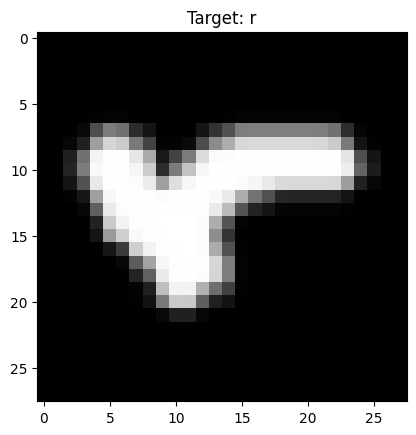

In [33]:
# 1. Install missing tools
!pip install opendatasets --upgrade --quiet

import os
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Set your Credentials (Bypasses the manual prompt)
os.environ['KAGGLE_USERNAME'] = "quzzalkhanam"
os.environ['KAGGLE_KEY'] = "6f8746e077d1451c433f7a264a6a7c58"

# 3. Download Dataset (Using the URL directly)
dataset_url = "https://www.kaggle.com/datasets/crawford/emnist"
od.download(dataset_url)

# 4. Load the Data (Defining 'data' clearly to fix the NameError)
# The file is saved in a folder named 'emnist'
file_path = './emnist/emnist-balanced-train.csv'

if os.path.exists(file_path):
    # Load the CSV into the 'data' variable
    data = pd.read_csv(file_path, header=None)

    # Extract Labels and Images
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:].values.reshape(-1, 28, 28)

    # Apply the Rotation Fix (The Kaggle Secret)
    X = np.array([np.rot90(np.fliplr(img)) for img in X])
    X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Success Mapping
    class_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"
    print(f"✅ 'data' is now defined! Loaded {len(data)} rows.")

    # Show a sample to prove it works
    plt.imshow(X[0].reshape(28,28), cmap='gray')
    plt.title(f"Target: {class_map[y[0]]}")
    plt.show()
else:
    print("❌ Error: File not found. Check if the download completed.")

Fix Image Orientation

✅ Orientation Fixed! train_images shape: (112800, 28, 28, 1)


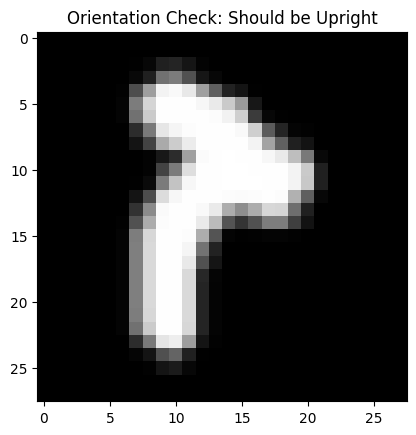

In [35]:
# 1. Define the fix function so the computer knows what it is
def fix_emnist_orientation(img_data):
    # Reshape to 28x28 squares
    img_data = img_data.reshape(-1, 28, 28)
    # Rotate and Flip (The Kaggle standard fix)
    fixed_data = np.array([np.rot90(np.fliplr(img)) for img in img_data])
    # Reshape back for the CNN (Adding the 1 color channel)
    return fixed_data.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 2. Link your 'X' data to the names you want to use
# (This fixes the 'name not defined' error)
train_images = X  # X was created in our previous successful step

# 3. RUN THE FIX
train_images = fix_emnist_orientation(train_images)

print(f"✅ Orientation Fixed! train_images shape: {train_images.shape}")

# 4. Visual Confirmation
plt.imshow(train_images[0].reshape(28,28), cmap='gray')
plt.title("Orientation Check: Should be Upright")
plt.show()

Normalize Image

In [38]:
from sklearn.model_selection import train_test_split

# 1. Split the data (80% for training, 20% for testing)
# This creates the 'test_images' variable your code is looking for
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Variables defined! train_images: {train_images.shape}, test_images: {test_images.shape}")
# Now this will work because 'test_images' is defined above
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

print("✅ Normalization complete.")

✅ Variables defined! train_images: (90240, 28, 28, 1), test_images: (22560, 28, 28, 1)
✅ Normalization complete.


Make Labels Writable

In [39]:
# Make labels writable
train_labels = train_labels.copy()
test_labels = test_labels.copy()

Fix Label Range (1-26 ➝ 0-25)

In [40]:
# The EMNIST balanced dataset labels are already 0-46, so no decrement is needed.
# If labels were 1-N, this would convert them to 0-(N-1).
# Since they are already 0-46 for 47 classes, we do not need to perform this step.
# train_labels -= 1
# test_labels -= 1

Preliminary Data Review

Check Shape of Training and Test Data

In [41]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (90240, 28, 28, 1)
Train labels shape: (90240,)
Test images shape: (22560, 28, 28, 1)
Test labels shape: (22560,)


Visualize a Few Samples

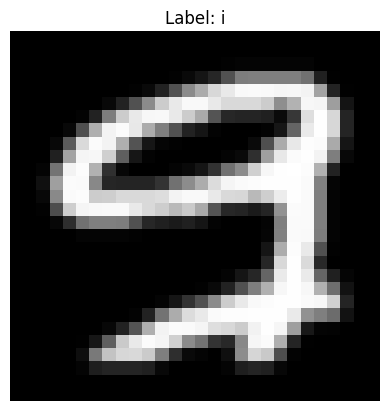

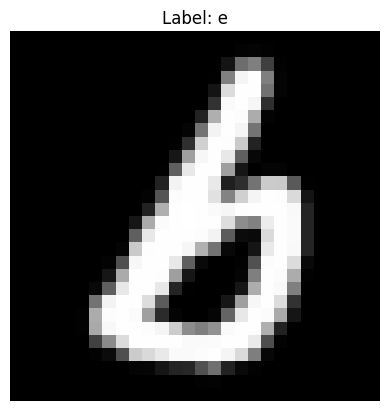

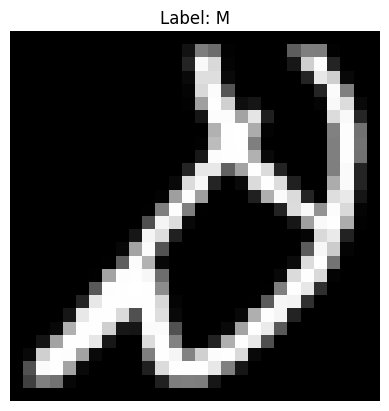

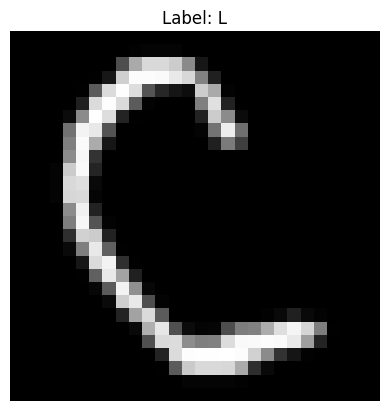

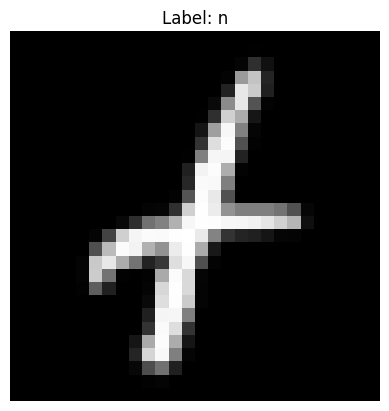

In [42]:
show_samples(train_images, train_labels, num=5)

Check for Class Distribution

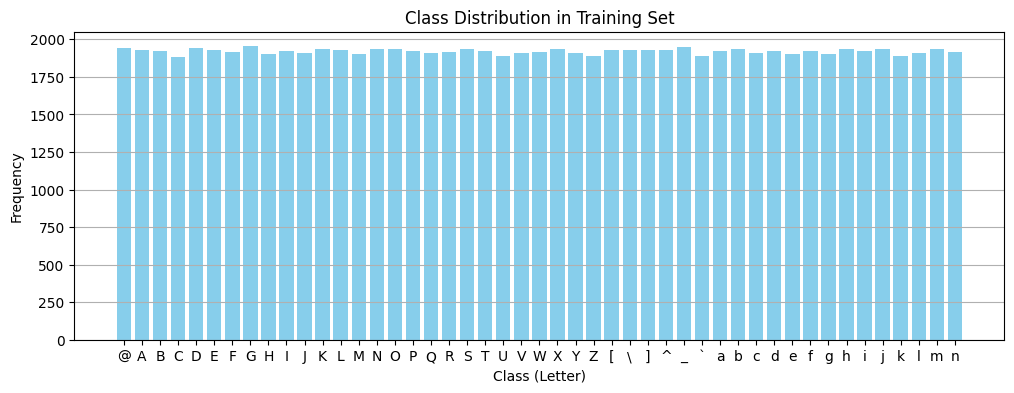


Training class distribution:
@: 1943
A: 1928
B: 1921
C: 1885
D: 1940
E: 1927
F: 1916
G: 1953
H: 1904
I: 1920
J: 1906
K: 1935
L: 1931
M: 1900
N: 1935
O: 1933
P: 1919
Q: 1910
R: 1918
S: 1936
T: 1920
U: 1892
V: 1912
W: 1916
X: 1936
Y: 1906
Z: 1889
[: 1928
\: 1927
]: 1930
^: 1932
_: 1946
`: 1890
a: 1923
b: 1936
c: 1912
d: 1923
e: 1901
f: 1923
g: 1899
h: 1935
i: 1924
j: 1936
k: 1887
l: 1907
m: 1934
n: 1916


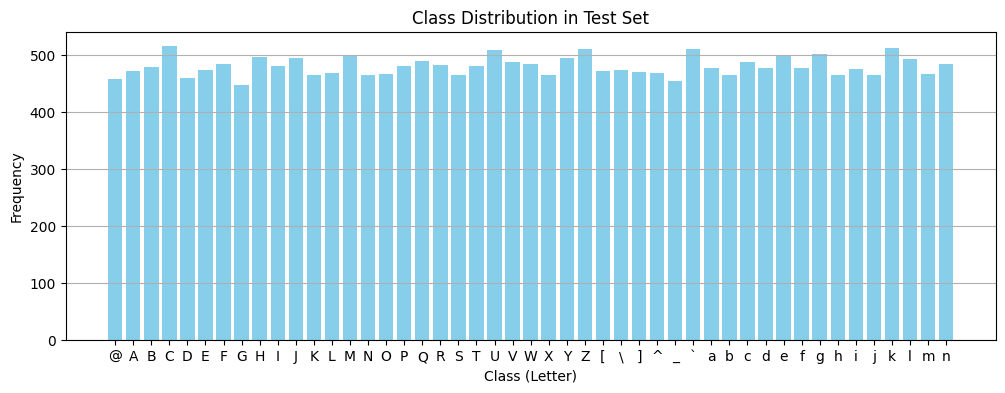


Test class distribution:
@: 457
A: 472
B: 479
C: 515
D: 460
E: 473
F: 484
G: 447
H: 496
I: 480
J: 494
K: 465
L: 469
M: 500
N: 465
O: 467
P: 481
Q: 490
R: 482
S: 464
T: 480
U: 508
V: 488
W: 484
X: 464
Y: 494
Z: 511
[: 472
\: 473
]: 470
^: 468
_: 454
`: 510
a: 477
b: 464
c: 488
d: 477
e: 499
f: 477
g: 501
h: 465
i: 476
j: 464
k: 513
l: 493
m: 466
n: 484


In [43]:
# Apply to training and test sets
plot_class_distribution(train_labels, dataset_name="Training")
plot_class_distribution(test_labels, dataset_name="Test")

Preprocessing

In [44]:
X_train = []
y_train = []
X_test = []
y_test = []

# Convert the training and test images and labels into separate Python lists
for img, label in zip(train_images, train_labels):
    X_train.append(img)
    y_train.append(label)

for img, label in zip(test_images, test_labels):
    X_test.append(img)
    y_test.append(label)

# Convert the list back to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print the shape of the newly created arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (90240, 28, 28, 1)
y_train shape: (90240,)


Set Random Seeds for Reproducibility

In [45]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

Add Channel Dimension to Grayscale Images

In [46]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Apply One-hot Encoding for Categorical Classification

In [56]:
from tensorflow.keras.utils import to_categorical

# 1. Change 26 to 47 to accommodate Digits and extra Letters
num_classes = 47

# 2. Convert to categorical
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"✅ Success! Labels converted for {num_classes} classes.")



✅ Success! Labels converted for 47 classes.


Visualize Images and their Labels

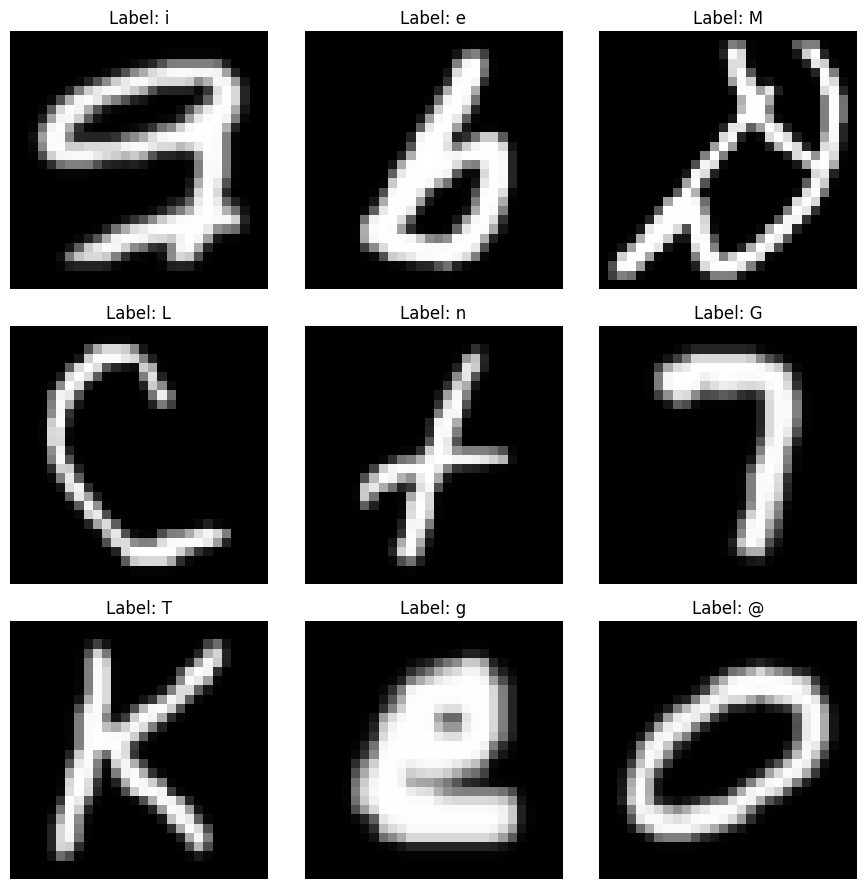

In [49]:
visualize_samples(X_train, train_labels, num_samples=9)

Build and Train Model

In [52]:
model = Sequential([
    Input(shape=(28, 28, 1)),              # Explicit input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')        # 26 output classes corresponding to A-Z
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# This clears the internal TensorFlow state
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(47, activation='softmax') # Ensure this is 47
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=10,
    batch_size=128
)

Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 74s 102ms/step - accuracy: 0.0721 - loss: 3.6086 - val_accuracy: 0.5228 - val_loss: 1.7749
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.4212 - loss: 2.0115 - val_accuracy: 0.6186 - val_loss: 1.3484
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 85s 108ms/step - accuracy: 0.4950 - loss: 1.7224 - val_accuracy: 0.6628 - val_loss: 1.1604
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - accuracy: 0.5366 - loss: 1.5712 - val_accuracy: 0.6903 - val_loss: 1.0549
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 72s 103ms/step - accuracy: 0.5629 - loss: 1.4632 - val_accuracy: 0.7057 - val_loss: 0.9766
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.5819 - loss: 1.3850 - val_accuracy: 0.7196 - val_loss: 0.9169
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 79s 111ms/step - accuracy: 0.5947 - loss: 1.3270 - val_accuracy: 0.7368 - val_loss: 0.8683
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 73s 103ms/step - accuracy: 0.6100 - loss: 1

Plot Model Performance

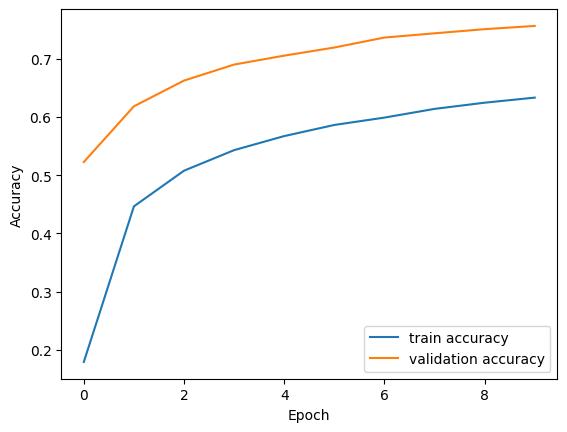

In [62]:
# Plot Model Performance
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model Evaluation and Prediction on Test Data

Predict the Test Data

In [64]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions on test data
pred_probs = model.predict(X_test, verbose=0)
pred_labels = pred_probs.argmax(axis=1)

705/705 - 8s - 12ms/step - accuracy: 0.7568 - loss: 0.7787
Test accuracy: 0.7568


Compare and Visualize Predictions

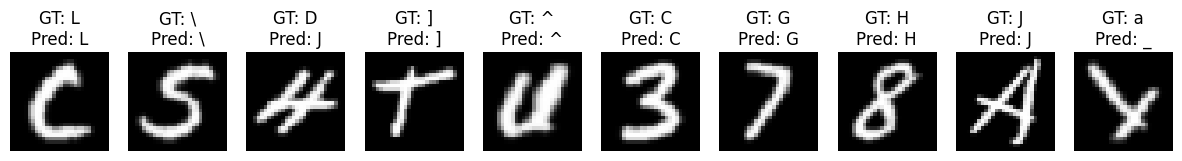

In [65]:
show_predictions(X_test, y_test, pred_labels, num_samples=10)

Plot Confusion Matrix for Train/Test Data

In [66]:
# Get train predictions
train_pred_probs = model.predict(X_train, verbose=0)
train_pred_labels = train_pred_probs.argmax(axis=1)

# Create confusion matrix
train_cm = confusion_matrix(y_train, train_pred_labels)
test_cm = confusion_matrix(y_test, pred_labels)

# Define class labels (A-Z)
class_labels = [chr(i) for i in range(ord('A'), ord('Z')+1)]

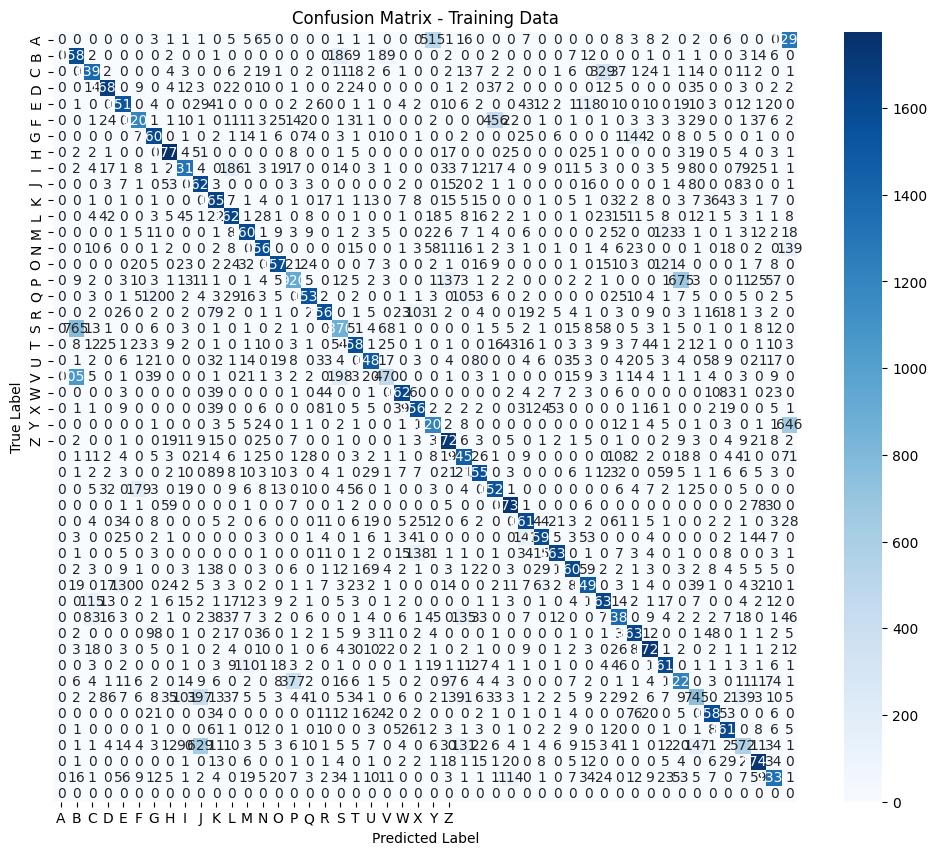

In [67]:
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Data')

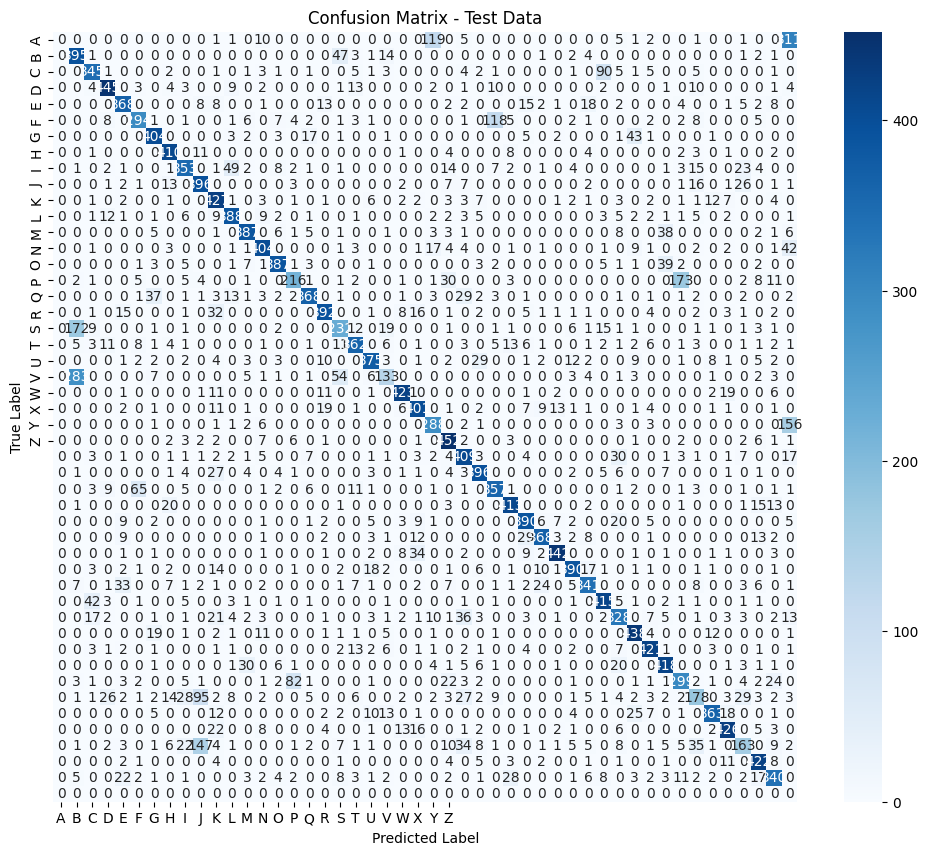

In [68]:
plot_confusion_matrix(test_cm, 'Confusion Matrix - Test Data')

Calculate Per-class Accuracy

In [75]:
# 1. The FULL 47-class mapping for EMNIST Balanced
full_emnist_labels = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt")

def analyze_confusion_matrix_safe(conf_matrix, labels_list):
    # Get True Positives (diagonal) and Total per class (row sums)
    true_positives = np.diag(conf_matrix)
    total_per_class = conf_matrix.sum(axis=1)

    # Calculate accuracy safely (avoid divide by zero)
    class_accuracies = np.where(total_per_class == 0, 0, true_positives / total_per_class)

    print("\n--- Class-wise Accuracies ---")
    # Loop ONLY as many times as we have labels to avoid IndexError
    num_to_print = min(len(labels_list), len(class_accuracies))

    for i in range(num_to_print):
        acc = class_accuracies[i]
        print(f"{labels_list[i]}: {acc*100:.2f}%")

    return class_accuracies

# 2. Run the safe function
test_class_accuracies = analyze_confusion_matrix_safe(test_cm, full_emnist_labels)

# 3. Best and Worst
best_idx = np.argmax(test_class_accuracies)
worst_idx = np.argmin(test_class_accuracies)
print(f"\n✅ Best Predicted: {full_emnist_labels[best_idx]} ({test_class_accuracies[best_idx]*100:.2f}%)")
print(f"✅ Worst Predicted: {full_emnist_labels[worst_idx]} ({test_class_accuracies[worst_idx]*100:.2f}%)")


--- Class-wise Accuracies ---
0: 0.00%
1: 83.69%
2: 72.03%
3: 86.41%
4: 80.00%
5: 62.16%
6: 83.47%
7: 91.72%
8: 71.17%
9: 82.50%
A: 86.44%
B: 83.44%
C: 82.52%
D: 80.80%
E: 83.23%
F: 46.25%
G: 76.51%
H: 80.00%
I: 48.13%
J: 78.02%
K: 78.12%
L: 26.18%
M: 86.68%
N: 82.85%
O: 62.07%
P: 91.50%
Q: 80.04%
R: 83.90%
S: 75.48%
T: 87.87%
U: 83.33%
V: 81.06%
W: 86.67%
X: 81.76%
Y: 73.49%
Z: 85.04%
a: 68.76%
b: 87.78%
d: 88.26%
e: 83.43%
f: 64.30%
g: 37.39%
h: 78.23%
n: 83.04%
q: 33.06%
r: 90.56%
t: 70.25%

✅ Best Predicted: 7 (91.72%)
✅ Worst Predicted: 0 (0.00%)


/tmp/ipython-input-3463176196.py:10: RuntimeWarning: invalid value encountered in divide
  class_accuracies = np.where(total_per_class == 0, 0, true_positives / total_per_class)


Plot the Result

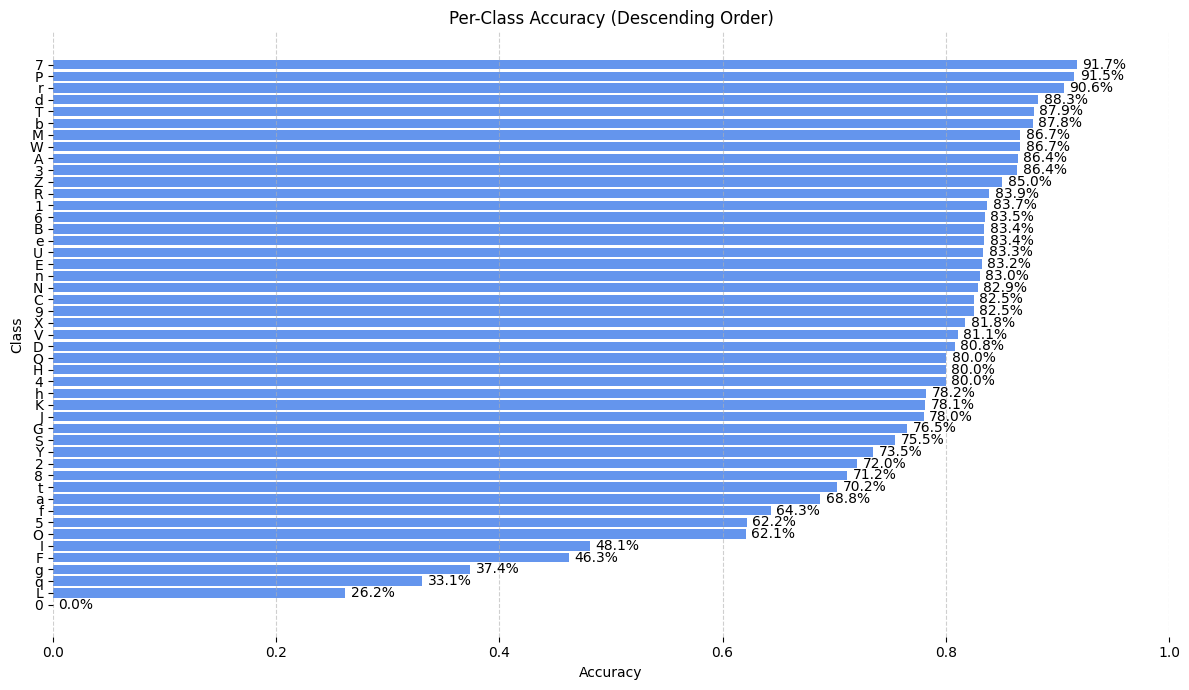

In [76]:
# Convert to list of (label, accuracy)
accuracy_pairs = list(zip(class_labels, test_class_accuracies))

# Sort descending by accuracy
sorted_accuracies = sorted(accuracy_pairs, key=lambda x: x[1], reverse=False)
sorted_labels, sorted_values = zip(*sorted_accuracies)

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(sorted_labels, sorted_values, color='cornflowerblue')

ax.set_xlabel("Accuracy")
ax.set_ylabel("Class")
ax.set_title("Per-Class Accuracy (Descending Order)")
ax.set_xlim(0, 1)
ax.grid(axis='x', linestyle='--', alpha=0.6)
ax.margins(x=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Annotate bars horizontally
def annotate_bars_horizontal(ax, fmt='both', fontsize=10, spacing=0.005):
    for bar in ax.patches:
        width = bar.get_width()
        if fmt == 'count':
            label = f'{width:.2f}'
        elif fmt == 'percent':
            label = f'{width * 100:.1f}%'
        elif fmt == 'both':
            label = f'{width:.2f} ({width * 100:.1f}%)'
        else:
            label = ''
        ax.annotate(label,
                    (width + spacing, bar.get_y() + bar.get_height() / 2),
                    ha='left', va='center', fontsize=fontsize)

annotate_bars_horizontal(ax, fmt='percent')

plt.tight_layout()
plt.show()

In [91]:
import gradio as gr
import numpy as np

# Re-define mapping locally
class_map_local = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"

def test_model_accuracy(char_idx):
    # 1. Find all available samples for this class in the test set
    indices = np.where(y_test == char_idx)[0]

    if len(indices) == 0:
        return "No data samples found in the test set for this character."

    # 2. Test up to 100 samples to get a real accuracy percentage
    num_to_test = min(len(indices), 100)
    test_indices = np.random.choice(indices, num_to_test, replace=False)

    correct_count = 0
    samples = X_test[test_indices].reshape(-1, 28, 28, 1)

    # 3. Batch Predict
    predictions = model.predict(samples, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    for pred in predicted_labels:
        if pred == char_idx:
            correct_count += 1

    accuracy = (correct_count / num_to_test) * 100

    # 4. Return a text-only report
    report = (
        f"--- Statistical Report for '{class_map_local[char_idx]}' ---\n\n"
        f"Total Samples Tested: {num_to_test}\n"
        f"Correctly Identified: {correct_count}\n"
        f"Model Accuracy for this Character: {accuracy:.1f}%\n\n"
        f"Conclusion: " + ("Strong Performance" if accuracy > 80 else "Needs Improvement")
    )

    return report

# Create the Simplified UI
with gr.Blocks() as demo:
    gr.Markdown("# 📊 EMNIST Model Accuracy Tester")
    gr.Markdown("Select a character to see how well the AI performs across 100 different test samples.")

    with gr.Row():
        char_dropdown = gr.Dropdown(
            choices=[(f"Test Character: {class_map_local[i]}", i) for i in range(47)],
            label="Select Character to Test",
            value=0
        )
        test_btn = gr.Button("🚀 Run Accuracy Test")

    with gr.Row():
        result_text = gr.Textbox(label="Test Results", lines=10)

    # Trigger test on selection or button click
    test_btn.click(test_model_accuracy, inputs=char_dropdown, outputs=result_text)
    char_dropdown.change(test_model_accuracy, inputs=char_dropdown, outputs=result_text)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e963f003dda0335692.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
